In [1]:
from typing import Tuple
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms

In [2]:
import os, sys
sys.path.append(os.path.abspath('..'))

from src.models.unet import UNet
from src.training.train import train
from src.data.datasets import ACDCDataset
from src.training.metrics import dice_score, DiceLoss, evaluate

In [3]:
npz = np.load('../../tagflow/sample_data/in_vivo_data.npz')
imt, r0 = npz['imt'], npz['r0']

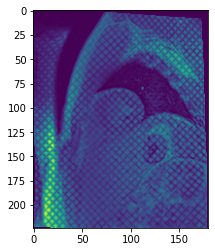

In [4]:
inp = imt[0]

plt.imshow(inp)

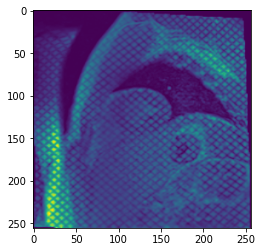

In [5]:
tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=np.mean(inp), std=np.std(inp)),
    transforms.Resize((256, 256))
])

model_input = tfs(inp).unsqueeze(0)

plt.imshow(model_input[0][0])

In [7]:
model: nn.Module = UNet(n_channels=1, n_classes=4, bilinear=True).double()
saved_model: nn.Module = torch.load('../checkpoints/model/model_cine_tag.pt')
if isinstance(saved_model, nn.DataParallel):
    saved_model = saved_model.module
model.load_state_dict(saved_model.state_dict())

<All keys matched successfully>

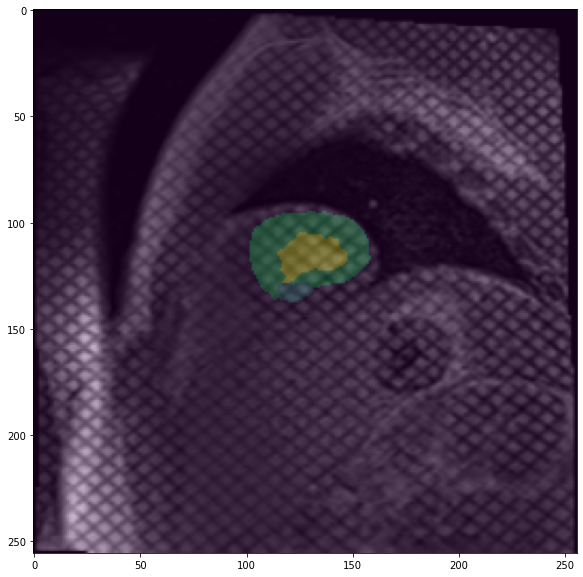

In [8]:
output = model(model_input.double())

out = F.softmax(output, dim=1).argmax(dim=1).detach().numpy()[0]

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(model_input[0][0], cmap='gray')
ax.imshow(out, alpha=0.3)